In [1]:
# Imports
import time
import pandas as pd
import numpy as np
import scipy
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt
# Plot settings for retina
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [24]:
# Filenames
f_name = 'single-proj_scenario.csv'
augmented_f_name = 'single-proj_scenario_with_text.csv'
out_f_name = 'pr_dataset.json'

In [3]:
# Create dataframe with PR data
def load_pr_data() -> pd.DataFrame:
    f_bots = 'bots.txt'
    with open(f_name) as f:
        raw_df = pd.read_csv(f_name)
    with open(f_bots) as f:
        bots = f.read().splitlines()
    return raw_df[~raw_df['Author'].isin(bots)]

In [4]:
raw_df = load_pr_data()

In [5]:
# Add empty "text" column
raw_df['Text'] = ''

In [6]:
# Hanle API tokens

class APIToken:
    def __init__(self):
        self.token_index = 0
        self.tokens = [
            'c8407e53938eea5e027377eb744efe67850f3e0a', # SA-2019
            '8657769a09149655d1942a975c074f6d9441da4a', # SA-2019
            '55866a3ccee6c1ee5e32727958687cd1ad29d55b'  # Pr_study_1
        ]
        
    def next(self):
        tok = self.tokens[self.token_index]
        self.token_index = (self.token_index + 1) % len(self.tokens)
        return tok

In [7]:
# Ask GitHub api for PR text

# Construct API url
def get_api_url(repo_url: str, pr_num: int) -> str:
    owner_repo = repo_url[len("https://github.com/"):]
    return f"https://api.github.com/repos/{owner_repo}/pulls/{pr_num}"

# Request pr and return PR title and body
def get_pr_text(full_url: str, tok: APIToken, retries: int) -> str:
    QUERY = { 'access_token': tok.next() }
    HEADERS = { 'Accept': "application/vnd.github.v3+json" }
    try:
        r = requests.get(url = full_url, params = QUERY, headers = HEADERS)
        if (r.status_code != 200):
            print(f"\tError in request: {r.text}")
            if ('Retry-After' in r.headers):
                print(f"\tRetrying after: {r.headers['Retry-After']}")
                time.sleep(r.headers['Retry-After'])
                return get_pr_text(full_url, tok, retries - 1)
            else:
                print(f"\tRate limit remaining: {r.headers['X-RateLimit-Remaining']}")
                return ''
        else:
            j = r.json()
            return j['title'] + '\n' + j['body']
    except ConnectionError:
        if (retries > 0):
            print(f"\tConnectionError in request for {repo_url}. Retrying ({retries} retries left).")
            time.sleep(10)
            return get_pr_text(full_url, tok, retries - 1)
        else:
            print(f"\tConnectionError in request for {repo_url}. Returning ''.")
            return ''
    except:
        print(f"\tUnknown error in request for {repo_url}. Returning ''.")
        return ''
    
def fetch_pr_texts(_df: pd.DataFrame) -> pd.DataFrame:
    # Request text for all PR in df, add retrieved text to df
    api_token = APIToken()
    for i in range(len(raw_df)):
        if (i > 4000):
            break
        row = raw_df.loc[i]
        repo_url = row['Repo']
        pr_num = row['PR_Number']
        URL = get_api_url(repo_url, pr_num)
        print(f"{i}: Requesting {URL}")
        text = get_pr_text(URL, api_token, retries = 5)
        raw_df.loc[i, 'Text'] = text
    raw_df.to_csv(augmented_f_name, index = False)
    return raw_df

In [8]:
def load_local_prs_with_text() -> pd.DataFrame:
    with open(augmented_f_name) as f:
        _df = pd.read_csv(f)
    return _df[~_df['Text'].isna()]

In [10]:
# Either load locally saved file, or re-load PR tests from GitHub

# df = fetch_pr_texts(raw_df)
df = load_local_prs_with_text()

In [11]:
def add_text_len(_df: pd.DataFrame) -> pd.DataFrame:
    return _df\
        .assign(TextLen=lambda d: d['Text'].str.len())

In [12]:
textlen_df = add_text_len(df)

In [13]:
textlen_df.head()

,Author,Repo,PR_Number,ClosingTime,GeneralCommentsReceived,SourceCodeCommentsReceived,AcceptancePercentage,Merged?,PastPR,PastCommits,...,AvgGeneralCommentsReceived,AvgSourceCodeCommentsReceived,AvgAcceptancePercentage,Senti4SDAvg-General,Senti4SDAvg-SourceCode,SentiSSEAvg-General,SentiSSEAvg-SourceCode,creationDate,Text,TextLen
0,AMecea,https://github.com/silverapp/silver,301,25.0,2.0,0.0,100.000000,True,0,1,...,NaN,NaN,NaN,0.0,NaN,0.0,NaN,2016-02-17T11:05:28Z,fix unicode exceptions.\nThis fix PressLabs/bi...,62
1,AMecea,https://github.com/presslabs/z3,8,827632.0,2.0,2.0,50.000000,False,1,4,...,NaN,NaN,NaN,0.0,0.0,0.0,-0.5,2016-08-10T16:17:50Z,fix reading from ~/.z3.cfg file for config and...,100
2,AMecea,https://github.com/silverapp/silver,358,1027.0,3.0,3.0,66.666664,True,2,4,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,2016-11-15T18:44:32Z,Test transactions\nfixes #344,29
3,AMecea,https://github.com/silverapp/silver,372,14575.0,1.0,9.0,50.000000,False,3,5,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,2016-11-18T08:05:04Z,Transaction state (fixes #364)\nCR\n\nfixes #364,46
4,AMecea,https://github.com/silverapp/silver,373,17.0,1.0,0.0,60.000000,True,4,5,...,1.8,2.8,0.6,0.0,NaN,0.0,NaN,2016-11-18T08:52:21Z,Add drone publish image. And fix requirment de...,57


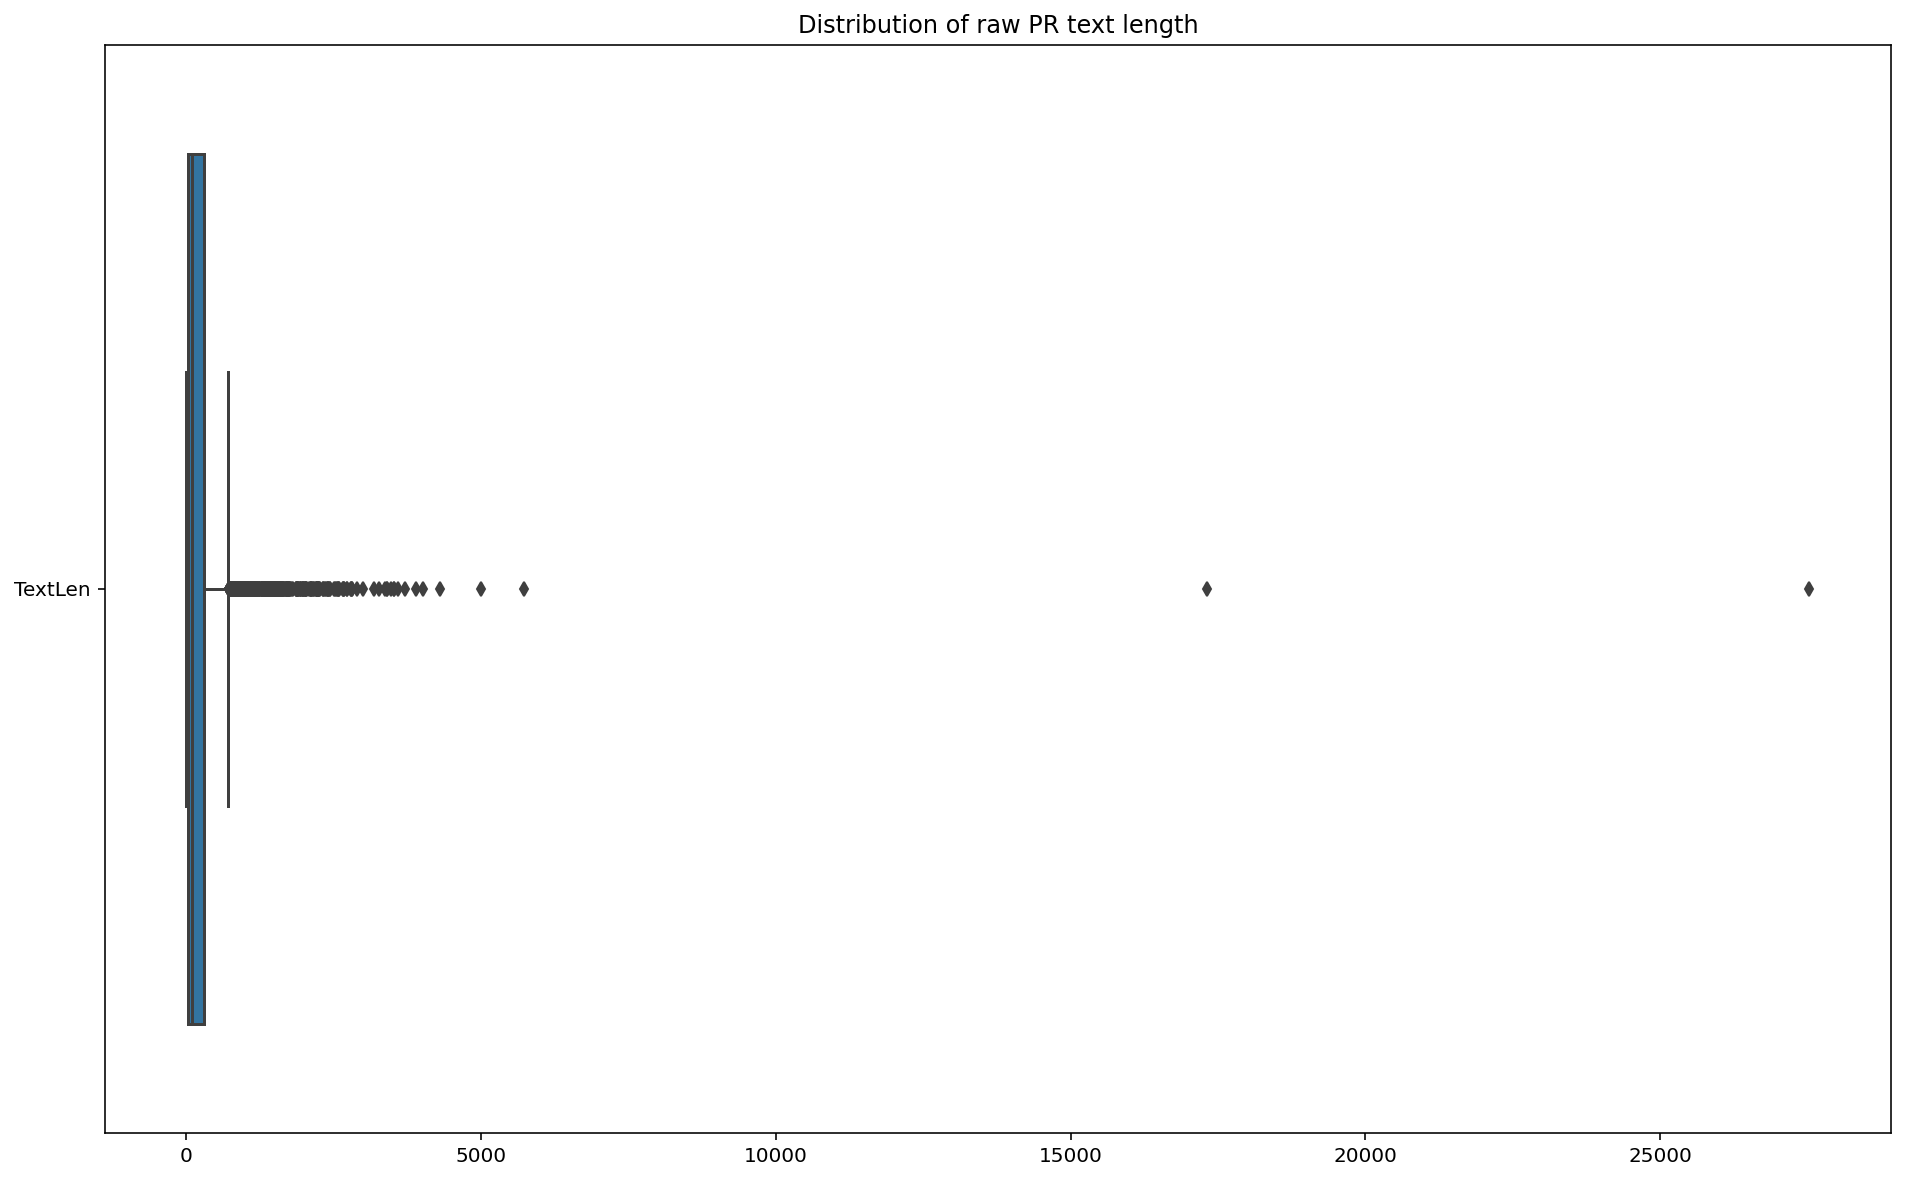

In [14]:
def textlen_distribution(_df: pd.DataFrame, title: str):
    plt.rcParams["figure.figsize"] = [16,10]
    sns.boxplot(orient="h", data=_df[['TextLen']]).set_title(title)
    
textlen_distribution(textlen_df, 'Distribution of raw PR text length')

In [15]:
def remove_outliers(_df: pd.DataFrame, use_z_score: bool = True) -> pd.DataFrame:
    if use_z_score:
        z_scores = scipy.stats.zscore(_df[['TextLen']])
        abs_z_scores = np.abs(z_scores)
        non_outlier = (abs_z_scores < 3).all(axis=1)
        return _df[non_outlier]
    else:
        Q1 = _df['TextLen'].quantile(0.25)
        Q3 = _df['TextLen'].quantile(0.75)
        IQR = Q3 - Q1
        outlier = (_df['TextLen'] < (Q1 - 1.5 * IQR)) | (_df['TextLen'] > (Q3 + 1.5 * IQR))
        return _df[~outlier]

In [16]:
def inspect_long_text(_df: pd.DataFrame, above: int = 2000):
    for i, t in _df[_df['TextLen'] > above].reset_index()['Text'].iteritems():
        print('_' * 100)
        print(t)
    
inspect_long_text(remove_outliers(textlen_df))

____________________________________________________________________________________________________
ERC721 safeTransfer new callback
Replaced ERC721TokenReceiver with new implementation, `onERC721Received(address, uint256, bytes) `-> `onERC721Received(address, address, uint256, bytes)`

```solidity
/// @dev Note: the ERC-165 identifier for this interface is 0x150b7a02.
interface ERC721TokenReceiver {
    /// @notice Handle the receipt of an NFT
    /// @dev The ERC721 smart contract calls this function on the recipient
    ///  after a `transfer`. This function MAY throw to revert and reject the
    ///  transfer. Return of other than the magic value MUST result in the
    ///  transaction being reverted.
    ///  Note: the contract address is always the message sender.
    /// @param _operator The address which called `safeTransferFrom` function
    /// @param _from The address which previously owned the token
    /// @param _tokenId The NFT identifier which is being transferred
    

In [17]:
def remove_short_and_dirty_text(_df: pd.DataFrame) -> pd.DataFrame:
    min_len = 50
    dirty_text = ['Documentação', 'Motivação', ': java.lang.']
    is_text_dirty = _df['Text'].str.contains('|'.join(dirty_text))
    is_text_too_short = (_df['TextLen'] < min_len)
    return _df[~is_text_dirty & ~is_text_too_short].reset_index(drop=True)

In [18]:
clean_df = remove_short_and_dirty_text(remove_outliers(textlen_df, False))

In [19]:
inspect_long_text(clean_df, above=500)

____________________________________________________________________________________________________
Style formatting
Fixes the following:
- Consolidates model interfaces to a single "src/Models" import
- Standardizes Prettier configuration to match linter
- Replaces package lock with yarn lock for faster module resolution
- Formats almost every component to meet Prettier default style guide settings

At heart, I just ran a formatter against every file individually and committed these results. I replaced Model imports with a shared "src/Models" since I have exported every model in the index.ts file.
____________________________________________________________________________________________________
Add Material Loader and nametag support
This pull request features the following:
- Adds support for the Material Loader from Three (finally!) and fixes some grouping issues. 
- Replaces TGA ball diffuse file with easier PNG and material map. 
- Reduces the material count for the player from

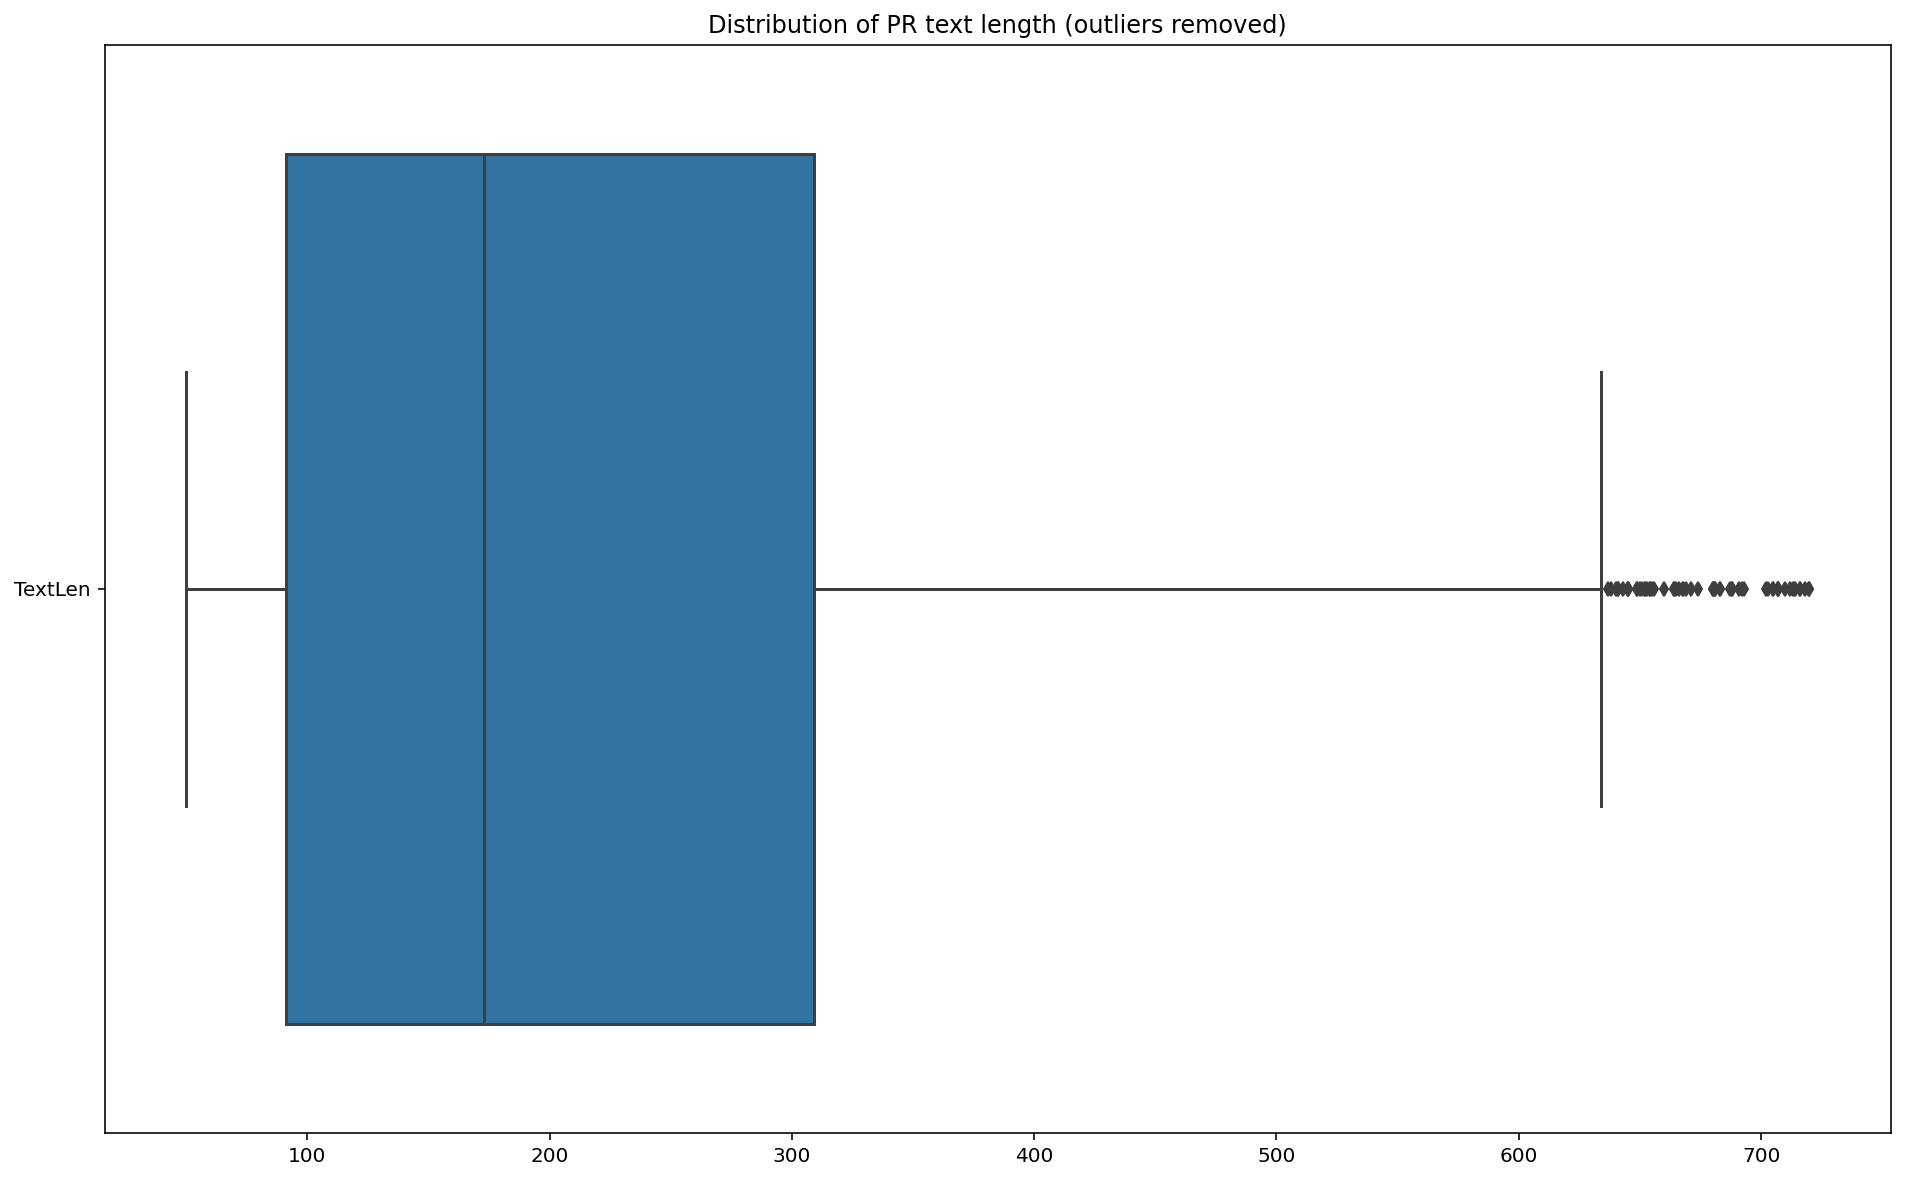

In [20]:
textlen_distribution(clean_df, 'Distribution of PR text length (outliers removed)')

In [21]:
clean_df.describe()

,PR_Number,ClosingTime,GeneralCommentsReceived,SourceCodeCommentsReceived,AcceptancePercentage,PastPR,PastCommits,AvgClosingTime,AvgGeneralCommentsReceived,AvgSourceCodeCommentsReceived,AvgAcceptancePercentage,Senti4SDAvg-General,Senti4SDAvg-SourceCode,SentiSSEAvg-General,SentiSSEAvg-SourceCode,TextLen
count,2231.000000,2.231000e+03,2231.000000,2231.000000,2231.000000,2231.000000,2231.000000,1985.000000,2138.000000,2138.000000,2138.000000,1435.000000,610.000000,1435.000000,610.000000,2231.000000
mean,2576.537875,1.358328e+04,2.073958,1.486329,85.189505,77.368893,473.664724,8013.281108,1.767259,1.298597,0.891674,0.271673,0.038795,0.265722,0.004830,219.873151
std,4966.886495,6.653637e+04,2.291023,5.123118,15.687328,75.179836,531.316350,18805.978915,1.480598,2.632024,0.180199,0.483649,0.299105,0.485454,0.279742,162.779238
min,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,50.000000
25%,78.000000,1.200000e+02,1.000000,0.000000,82.305502,17.000000,57.000000,671.600000,1.000000,0.000000,0.800000,0.000000,0.000000,0.000000,0.000000,91.000000
50%,399.000000,1.294000e+03,1.000000,0.000000,89.743590,53.000000,276.000000,2421.000000,1.400000,0.400000,1.000000,0.000000,0.000000,0.000000,0.000000,173.000000
75%,1189.500000,5.924500e+03,2.000000,1.000000,94.411673,118.500000,619.500000,7422.000000,2.200000,1.600000,1.000000,0.666667,0.049405,0.666667,0.000000,309.000000
max,35506.000000,1.552042e+06,30.000000,119.000000,100.000000,321.000000,2249.000000,226333.200000,13.800000,30.600000,1.000000,1.000000,1.000000,1.000000,1.000000,720.000000


In [25]:
# Write as JSON file
def write_json(_df: pd.DataFrame):
    _df.rename(columns={
        'Merged?' : 'IsMerged',
        'Senti4SDAvg-General' : 'Senti4SDAvgGeneral',
        'Senti4SDAvg-SourceCode' : 'Senti4SDAvgSourceCode',
        'SentiSSEAvg-General' : 'SentiSSEAvgGeneral',
        'SentiSSEAvg-SourceCode' : 'SentiSSEAvgSourceCode',
    }).to_json(out_f_name, orient='records')
    
write_json(clean_df)

In [26]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231 entries, 0 to 2230
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Author                         2231 non-null   object 
 1   Repo                           2231 non-null   object 
 2   PR_Number                      2231 non-null   int64  
 3   ClosingTime                    2231 non-null   float64
 4   GeneralCommentsReceived        2231 non-null   float64
 5   SourceCodeCommentsReceived     2231 non-null   float64
 6   AcceptancePercentage           2231 non-null   float64
 7   Merged?                        2231 non-null   bool   
 8   PastPR                         2231 non-null   int64  
 9   PastCommits                    2231 non-null   int64  
 10  AvgClosingTime                 1985 non-null   float64
 11  AvgGeneralCommentsReceived     2138 non-null   float64
 12  AvgSourceCodeCommentsReceived  2138 non-null   f